<a href="https://colab.research.google.com/github/youssef893/Arabic-Entity-Recognition/blob/main/Arabic_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all needed libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras import Input
from keras.models import Model

In [ ]:
import nltk
nltk.download('stopwords')
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
arabic_stop_word = stopwords.words('arabic')
stemmer = ISRIStemmer()

# Utilz

In [ ]:
def token_preprocessing(token):
  """
  parameter: 
    token: string contain word

    return: 
      token: the word after removing preffix and suffix (get the original word)
      true: if it is not a stop word
  """
  is_arabic = bool(re.match('^[ا-ى][أ-ي]', token))
  if token not in arabic_stop_word and is_arabic:
    token = stemmer.stem(token)
    return token, False
  
  return token, True
  

In [ ]:
def is_txt(file):
  """
    return true if this file extention

    parameters:
      file: string contains the full name of this file 
  """
  return file.split('.')[-1] == "txt"

In [ ]:
def get_sentences(file):
    """
    Parameters:
      file: string contains the full name of this file 


    Returns:
      sentences: array contains all sentences exist in this txt file
    """
  

    sentences = []

    with open(file) as f:
      lines = f.readlines()

    sentence = ""
    for line in lines:
      line = line.replace('.', '').split()
      if len(line) == 0: # then current line contains '.' or ','
        sentences.append(sentence)
        sentence = "" 
      else :
        sentence += f'{line[0]} '

    return sentences

    


In [ ]:
def get_tokens_labels_dict(file , old_dict):

    """
    adds new tokens and its labels to current train dictionary 

    Parameters:
      file: string contains the full name of this file 
      old_dict: dictionary contains token : label


    Returns:
      new_dict: dictionary contains cumulative tokens : labels 
    """

    new_dict = old_dict.copy()  

    with open(file) as f:
      lines = f.readlines()

    for line in lines:

      if len( line.split() ) == 0: # then current line is \n
        continue
      
      token , label = line.split()
      token, is_stopword = token_preprocessing(token)

      if is_stopword:
        continue
      
      if token not in new_dict.keys():
        new_dict[token] = label


    return new_dict


## Loading Data

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/AQMAR_Arabic_NER_corpus-1.0.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('AQMAR')
   print('File is unzipped in AQMAR folder') 

File is unzipped in AQMAR folder


In [ ]:
data_folder = "/content/AQMAR"
files = sorted(os.listdir(data_folder))

In [ ]:
for i , file in enumerate(files):
    print(f'i = {i+1} | File = {file}')
    
print(f'\nExample For A Full Path {data_folder}/{file}')

i = 1 | File = Atom.txt
i = 2 | File = Christiano_Ronaldo.txt
i = 3 | File = Computer.txt
i = 4 | File = Computer_Software.txt
i = 5 | File = Crusades.txt
i = 6 | File = Damascus.txt
i = 7 | File = Enrico_Fermi.txt
i = 8 | File = Football.txt
i = 9 | File = Ibn_Tolun_Mosque.txt
i = 10 | File = Imam_Hussein_Shrine.txt
i = 11 | File = Internet.txt
i = 12 | File = Islamic_Golden_Age.txt
i = 13 | File = Islamic_History.txt
i = 14 | File = LICENSE
i = 15 | File = Light.txt
i = 16 | File = Linux.txt
i = 17 | File = Nuclear_Power.txt
i = 18 | File = Periodic_Table.txt
i = 19 | File = Physics.txt
i = 20 | File = Portugal_football_team.txt
i = 21 | File = README
i = 22 | File = Raul_Gonzales.txt
i = 23 | File = Razi.txt
i = 24 | File = Real_Madrid.txt
i = 25 | File = Richard_Stallman.txt
i = 26 | File = Soccer_Worldcup.txt
i = 27 | File = Solaris.txt
i = 28 | File = Summer_Olympics2004.txt
i = 29 | File = Ummaya_Mosque.txt
i = 30 | File = VERSION
i = 31 | File = X_window_system.txt
i = 32 | Fil

In [ ]:
txt_files = []
for i , file in enumerate(files):
    if is_txt(file):
      txt_files.append(f'{data_folder}/{file}')

In [ ]:
txt_files

['/content/AQMAR/Atom.txt',
 '/content/AQMAR/Christiano_Ronaldo.txt',
 '/content/AQMAR/Computer.txt',
 '/content/AQMAR/Computer_Software.txt',
 '/content/AQMAR/Crusades.txt',
 '/content/AQMAR/Damascus.txt',
 '/content/AQMAR/Enrico_Fermi.txt',
 '/content/AQMAR/Football.txt',
 '/content/AQMAR/Ibn_Tolun_Mosque.txt',
 '/content/AQMAR/Imam_Hussein_Shrine.txt',
 '/content/AQMAR/Internet.txt',
 '/content/AQMAR/Islamic_Golden_Age.txt',
 '/content/AQMAR/Islamic_History.txt',
 '/content/AQMAR/Light.txt',
 '/content/AQMAR/Linux.txt',
 '/content/AQMAR/Nuclear_Power.txt',
 '/content/AQMAR/Periodic_Table.txt',
 '/content/AQMAR/Physics.txt',
 '/content/AQMAR/Portugal_football_team.txt',
 '/content/AQMAR/Raul_Gonzales.txt',
 '/content/AQMAR/Razi.txt',
 '/content/AQMAR/Real_Madrid.txt',
 '/content/AQMAR/Richard_Stallman.txt',
 '/content/AQMAR/Soccer_Worldcup.txt',
 '/content/AQMAR/Solaris.txt',
 '/content/AQMAR/Summer_Olympics2004.txt',
 '/content/AQMAR/Ummaya_Mosque.txt',
 '/content/AQMAR/X_window_sys

In [ ]:
# train_X = [get_sentences(txt_file) for txt_file in txt_files]

In [ ]:
# len(train_X)

In [ ]:
train_data = {}

for txt_file in txt_files:
    train_data = get_tokens_labels_dict(txt_file , train_data)

In [ ]:
len(train_data)

4747

In [ ]:
tokens , labels = list(train_data.keys()) , list(train_data.values())

In [ ]:
word = pd.DataFrame(labels)
word.value_counts()

O         3661
B-PER      273
I-PER      215
B-LOC      196
B-MIS1      93
I-LOC       90
I-ORG       47
B-ORG       41
I-MIS1      30
B-MIS2      25
B-MIS3      22
I-MIS2      21
B-MIS0      15
I-MIS0      13
I-MIS3       5
dtype: int64

In [ ]:
print(f'First Token is {tokens[0]} And Its label is {labels[0]}')
len(tokens) == len(labels)
output_length = len(set(labels))
output_length

First Token is ذرة And Its label is O


15

In [ ]:
set(labels)

{'B-LOC',
 'B-MIS0',
 'B-MIS1',
 'B-MIS2',
 'B-MIS3',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MIS0',
 'I-MIS1',
 'I-MIS2',
 'I-MIS3',
 'I-ORG',
 'I-PER',
 'O'}

# **PREPARING DATA**

Prepare data to model by encoding it into integers and one hot encoding then makes sequence from text 


In [ ]:
def encode_text(tokens):
  """
    Parameters:
      tokens: it is the all word

    Return:
      tokens: after encoding it using one hot encoder
  """
  tokens = np.array(tokens)
  onehot_encoder = OneHotEncoder(sparse=False)
  tokens = tokens.reshape(-1, 1)
  tokens = onehot_encoder.fit_transform(tokens)
  return tokens

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)

In [ ]:
tokens = encode_text(tokens)
labels = encode_text(labels)

In [ ]:
pad_tokens = pad_sequences(tokens, maxlen=10, padding='post')

In [ ]:
len(pad_tokens)

4747

In [ ]:
labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Splite data into train, validation and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(pad_tokens, labels, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Recognition Model

Download pretrained word2vec model for arabic ===> aravec model

In [ ]:
""" Both of them give same accuracy """
# !wget https://archive.org/download/aravec2.0/tweet_cbow_300.zip  # This is model which train on 132,750,000 documents
# !wget https://archive.org/download/aravec2.0/www_cbow_300.zip  # This is model which train on 66,900,000 documents 

' Both of them give same accuracy '

In [ ]:
# !unzip -q tweet_cbow_300  

# !unzip -q www_cbow_300  


In [ ]:
aravec_embeddings_index = {}
TOTAL_EMBEDDING_DIM = 300
embeddings_model_path = '/content/tweets_cbow_300'

aravec_model = KeyedVectors.load(embeddings_model_path)  # load word2vec model
# loop to getting values of words
for word in aravec_model.wv.vocab:
   aravec_embeddings_index[word] = aravec_model[word]

print('Loaded %s word vectors.'% len(aravec_embeddings_index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Loaded 331679 word vectors.


In [ ]:
# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, TOTAL_EMBEDDING_DIM))
print(tokenizer.word_index.items(), tokenizer.word_index)
for word, i in tokenizer.word_index.items():
    embedding_vector = aravec_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('Embedding Matrix shape:', embedding_matrix.shape)

dict_items([('ذرة', 1), ('جزء', 2), ('عنصر', 3), ('كيميائ', 4), ('خصص', 5), ('كيميائية', 6), ('لذلك', 7), ('كلم', 8), ('غرق', 9), ('وتع', 10), ('قبل', 11), ('قسم؛', 12), ('تتك', 13), ('سحب', 14), ('شحن', 15), ('سلب', 16), ('كترو', 17), ('تحم', 18), ('حول', 19), ('نوة', 20), ('وجب', 21), ('صغر', 22), ('جدا', 23), ('وسط', 24), ('روتو', 25), ('ورو', 26), ('عادل', 27), ('بقة', 28), ('عناصر؛', 29), ('غصن', 30), ('ادة', 31), ('نلق', 32), ('بنى', 33), ('فرق', 34), ('مثل', 35), ('برت', 36), ('حدد', 37), ('ثلا', 38), ('حمل', 39), ('خصائص؛', 40), ('عدد', 41), ('بروتونات', 42), ('كتل', 43), ('وزع', 44), ('صنع', 45), ('خلف', 46), ('صور', 47), ('نفس', 48), ('سمة', 49), ('نظر', 50), ('كون', 51), ('قدر', 52), ('خوض', 53), ('فعل', 54), ('ظل', 55), ('ركب', 56), ('علم', 57), ('بلغ', 58), ('زال', 59), ('علماء', 60), ('كشف', 61), ('زيد', 62), ('ظهر', 63), ('فرع', 64), ('جدد', 65), ('عها', 66), ('بدئ', 67), ('خصة', 68), ('بدء', 69), ('بدأ', 70), ('عدم', 71), ('أكد', 72), ('لثق', 73), ('رور', 74), ('وحد', 7

In [ ]:
# load embedding layer and set it's weights
embedding_layer = Embedding(vocab_size, TOTAL_EMBEDDING_DIM, weights=[embedding_matrix], input_length=10, trainable=False)

In [ ]:
# define model
input_placeholder = Input(shape=(10,))
input_embedding = embedding_layer(input_placeholder)
hidden_layer = Dense(100, activation='relu', name = 'layer1')(input_embedding)
lstm = LSTM(units=50, activation='tanh', name='lstm1')(hidden_layer)
output = Dense(output_length, activation='sigmoid', name = 'activation')(lstm)
model = Model(inputs=input_placeholder, outputs=output)

In [ ]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adamax(lr=0.001), metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 10, 300)           1425300   
                                                                 
 layer1 (Dense)              (None, 10, 100)           30100     
                                                                 
 lstm1 (LSTM)                (None, 50)                30200     
                                                                 
 activation (Dense)          (None, 15)                765       
                                                                 
Total params: 1,486,365
Trainable params: 61,065
Non-trainable params: 1,425,300
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, verbose=1)

Epoch 1/50
95/95 [==============================] - 5s 19ms/step - loss: 0.4174 - accuracy: 0.7642 - val_loss: 0.1195 - val_accuracy: 0.7737
Epoch 2/50
95/95 [==============================] - 1s 13ms/step - loss: 0.1120 - accuracy: 0.7718 - val_loss: 0.1069 - val_accuracy: 0.7737
Epoch 3/50
95/95 [==============================] - 1s 14ms/step - loss: 0.1071 - accuracy: 0.7718 - val_loss: 0.1053 - val_accuracy: 0.7737
Epoch 4/50
95/95 [==============================] - 1s 13ms/step - loss: 0.1062 - accuracy: 0.7718 - val_loss: 0.1050 - val_accuracy: 0.7737
Epoch 5/50
95/95 [==============================] - 1s 14ms/step - loss: 0.1060 - accuracy: 0.7718 - val_loss: 0.1048 - val_accuracy: 0.7737
Epoch 6/50
95/95 [==============================] - 1s 15ms/step - loss: 0.1059 - accuracy: 0.7718 - val_loss: 0.1049 - val_accuracy: 0.7737
Epoch 7/50
95/95 [==============================] - 1s 14ms/step - loss: 0.1059 - accuracy: 0.7718 - val_loss: 0.1048 - val_accuracy: 0.7737
Epoch 8/50
95

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
prediction = model.predict(x_test)
print('Accuracy: %f' % (accuracy*100), loss)

Accuracy: 76.736844 0.10739338397979736


In [ ]:
x, y = [], []
for i, j in zip(prediction, y_test):
  x.append(np.argmax(i))
  y.append(np.argmax(j))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
cf_matrix = confusion_matrix(x, y)

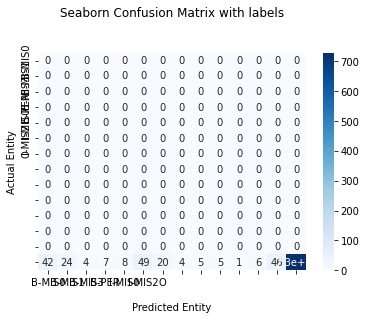

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title(f'Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Entity')
ax.set_ylabel('Actual Entity')
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['B-MIS0', 'B-MIS1', 'B-MIS3', 'B-PER', 'I-MIS0', 'I-MIS2', 'O'])
ax.yaxis.set_ticklabels(['B-MIS0', 'B-MIS1', 'B-MIS3', 'B-PER', 'I-MIS0', 'I-MIS2', 'O'])
# Display the visualization of the Confusion Matrix.
plt.show()

# Plot Fitting

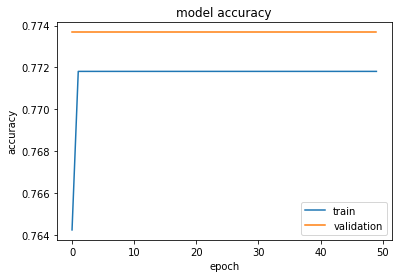

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

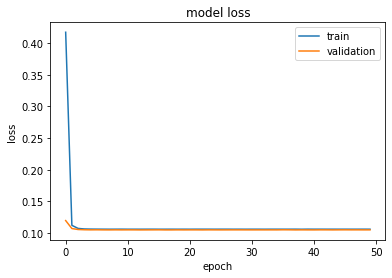

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
labels = ['B-LOC',
 'B-MIS0',
 'B-MIS1',
 'B-MIS2',
 'B-MIS3',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MIS0',
 'I-MIS1',
 'I-MIS2',
 'I-MIS3',
 'I-ORG',
 'I-PER',
 'O']

In [ ]:
word = 'أتوموس'
word, _ = token_preprocessing(word)
word = encode_text(word)
word = pad_sequences(word, maxlen=10, padding='post')
prediction = model.predict(word)
index = prediction.argmax()
labels[index]

'O'

# Conculsion
After plotting the confusion matrix we can conclude that:
  The data is unbalance 'O' label has very large number of points is 403 from   405 so the model is biased to this label so the model calssify all entity as 'O' one of ways to resolve this problem increasing data by collecting new data or make copy of it to increase small classes by using below code but it not work well with this model gives 15% for validation



In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler()
# tokens, labels = ros.fit_resample(np.array(tokens).reshape(-1, 1), labels)

# # check distribution after applying over sampling 
# word = pd.DataFrame(labels)
# tokens = tokens.tolist()
# word.value_counts()